In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors
from scipy import stats

In [2]:
# Import Data from NOAA GHCN-D CSVs
season_19_20 = pd.read_csv('2019-2020.csv')
season_18_19 = pd.read_csv('2018-2019.csv')
season_17_18 = pd.read_csv('2017-2018.csv')
season_16_17 = pd.read_csv('2016-2017.csv')
season_15_16 = pd.read_csv('2015-2016.csv')

In [3]:
station_list = ['USC00048758','USC00420072','USC00058575','USC00484910','USC00353402','USC00057936']
station_names = ['Tahoe City CA','Alta UT','Vail CO','Jackson WY','Mt. Hood OR','Steamboat Springs CO']

all_years = pd.concat([season_15_16, season_16_17, season_17_18, season_18_19, season_19_20])

all_years.set_index('STATION',inplace=True)
all_years = all_years[all_years != 0] # Converting any 0 values to Nan's

In [4]:
# Calculate average temperature from max/min and convert from Fahrenheit to Celsius

all_years.TAVG = list(map(lambda temp_max,temp_min: (temp_max + temp_min)/2 , all_years.TMAX, all_years.TMIN))

all_years.TAVG = list(map(lambda avg_temp: (avg_temp-32)*(5/9), all_years.TAVG))

In [8]:
class SLRanalysis:
    
    def __init__(self,location):
        self.location = location
    
    def calculate_snow_ratio(self):
        
        location_snow = self.location
        
        location_snow = location_snow[location_snow['SNOW'].notna()] # Find the days with snowfall
    
        location_snow = location_snow[location_snow['TAVG'] < 0.1 ] # Subset to snow events where tavg is less than 0
    
        location_snow['RATIO'] = location_snow.SNOW/location_snow.PRCP
    
        location_snow.set_index('DATE', inplace = True) 
    
        self.loc_mean = location_snow['SNOW'].mean()
        self.loc_ratio_mean = location_snow['RATIO'].mean()
        
        self.location = location_snow

    def plot_snow_ratio(self, name):
        fig = plt.figure(figsize=(16, 10))
        ax = fig.add_subplot(111)
        ax.grid(True)
        
        self.name = name
        
        location_snow_scatter = self.location.copy()
        
        location_snow_scatter.index = range(0,len(location_snow_scatter))

        snow_column = location_snow_scatter['SNOW']
        
        ### Subsetting for snowfall events above the mean snowfall.
        
        under_mean = snow_column.ge(location_snow_scatter['SNOW'].mean(), fill_value=0)
        index_names = location_snow_scatter[~under_mean].index
        location_snow_scatter.drop(index_names, inplace=True)

        ### Create color table for temperatures
        
        bounds = [-20,-15,-10,-5,0]
        colors = ["darkmagenta", "mediumslateblue", "blue", "cornflowerblue", "forestgreen"]

        cmap = matplotlib.colors.ListedColormap(colors)
        norm = matplotlib.colors.BoundaryNorm(bounds, len(colors))

        ### Plot data
        
        colored_plot = plt.scatter(location_snow_scatter['SNOW'],location_snow_scatter['RATIO'], s = 10**2, c=location_snow_scatter['TAVG'], cmap = cmap, norm=norm, alpha=0.5)
        cbar = plt.colorbar(colored_plot)
        cbar.set_label('Average Daily Temperature (°C)', labelpad = 15, rotation=270)
        plt.title(name + ' Snowfall Days >= Mean Snowfall', fontsize=14)

        ### Computing linear regression for snowfall events
        
        self.loc_slope, self.loc_intercept,self.loc_r_squared = self.compute_regression(location_snow_scatter)

        ### Plotting line

        linefitline = self.loc_slope*location_snow_scatter['SNOW'] + self.loc_intercept

        ax.plot(location_snow_scatter['SNOW'],linefitline,color='Red', linewidth=2, linestyle='solid', label='Linear Regression')

        plt.rc('font', size=10)          # controls default text sizes
        plt.rc('axes', titlesize=10)     # fontsize of the axes title
        plt.rc('axes', labelsize=12)    # fontsize of the x and y labels
        plt.rc('xtick', labelsize=10)    # fontsize of the tick labels
        plt.rc('ytick', labelsize=10)    # fontsize of the tick labels
        plt.rc('legend', fontsize=10)    # legend fontsize
        plt.rc('figure', titlesize=12)  # fontsize of the figure title

        legend = ax.legend(loc=1)
        ax.set_ylabel('Snow to Liquid Ratio', fontsize=14) #'Snow to Liquid Ratio (Snow(Inches)/1 Inch of Liquid Water)')
        ax.set_xlabel('Daily Accumulated Snowfall Depth (Inches)')

        plt.show()
    
    def compute_regression(self,location_snow_scatter):
        
        snow_column_reg = location_snow_scatter['SNOW']
        ratio_column_reg = location_snow_scatter['RATIO']

        snow_column_reg_inter = snow_column_reg.interpolate(method='linear', axis=0)
        ratio_column_reg_inter = ratio_column_reg.interpolate(method='linear', axis=0)
        snow_column_reg_inter_sqrt = np.sqrt(snow_column_reg_inter)

        self.loc_slope, self.loc_intercept, r_value, self.loc_p_value, self.loc_std_err = stats.linregress(snow_column_reg_inter,ratio_column_reg_inter)

        self.loc_r_squared = r_value*r_value

        return self.loc_slope, self.loc_intercept, self.loc_r_squared
 
    def compute_region_stats(self):

        region_snow = self.location

        self.loc_ratio_var = region_snow['RATIO'].var(ddof=0)
        self.loc_snow_var = region_snow['SNOW'].var(ddof=0)

        self.loc_ratio_stdev = region_snow['RATIO'].std(ddof=0)
        self.loc_snow_stdev =region_snow['SNOW'].std(ddof=0)
        
    def make_table(self):
        dict_one = {
        'Name' : [self.name],
        'Snow Mean (in)' : [np.round(self.loc_mean,3)],
        'Ratio Mean' : [np.round(self.loc_ratio_mean,3)],
        'Snow Stdev (in)' : [np.round(self.loc_snow_stdev,3)],
        'Ratio Stdev' : [np.round(self.loc_ratio_stdev,3)],
        'Slope' : [np.round(self.loc_slope,3)],
        'R^2': [np.round(self.loc_r_squared,3)]
        }
        
        table = pd.DataFrame(dict_one)
        print(table)

In [9]:
tahoe = all_years.loc[station_list[0]]
hood = all_years.loc[station_list[4]]

coast_region = pd.concat([tahoe,hood])

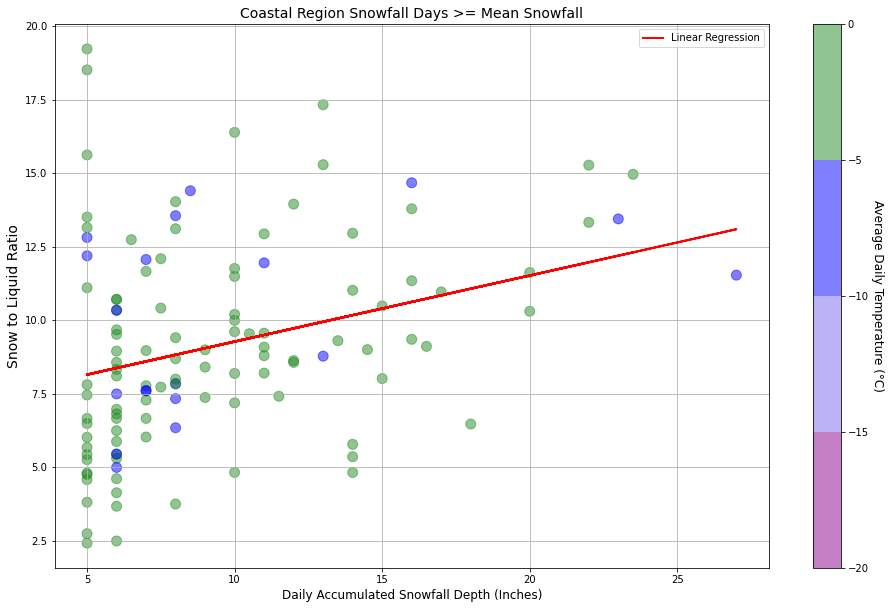

             Name  Snow Mean (in)  Ratio Mean  Snow Stdev (in)  Ratio Stdev  \
0  Coastal Region           4.575       8.604            4.736        4.856   

   Slope    R^2  
0  0.225  0.097  


In [10]:
coast = SLRanalysis(coast_region)

coast.calculate_snow_ratio()
coast.plot_snow_ratio('Coastal Region')
coast.compute_region_stats()
coast.make_table()

In [11]:
alta = all_years.loc[station_list[1]]
jackson = all_years.loc[station_list[3]]

mountain_region = pd.concat([alta, jackson])

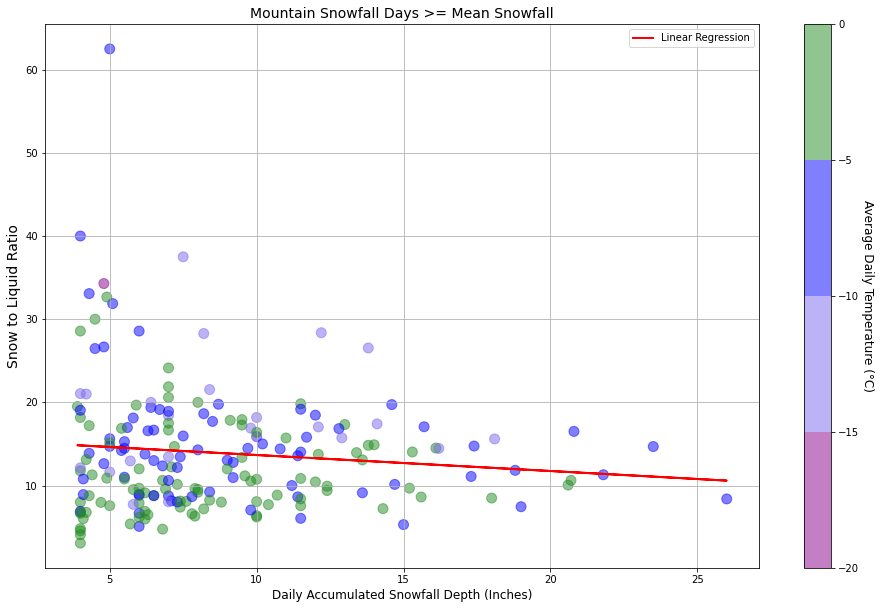

       Name  Snow Mean (in)  Ratio Mean  Snow Stdev (in)  Ratio Stdev  Slope  \
0  Mountain           3.896      15.208            4.389       10.714 -0.192   

     R^2  
0  0.012  


In [12]:
mountain = SLRanalysis(mountain_region)

mountain.calculate_snow_ratio()
mountain.plot_snow_ratio('Mountain')
mountain.compute_region_stats()
mountain.make_table()

In [13]:
vail = all_years.loc[station_list[2]]
steamboat = all_years.loc[station_list[5]]

continental_region = pd.concat([vail, steamboat])

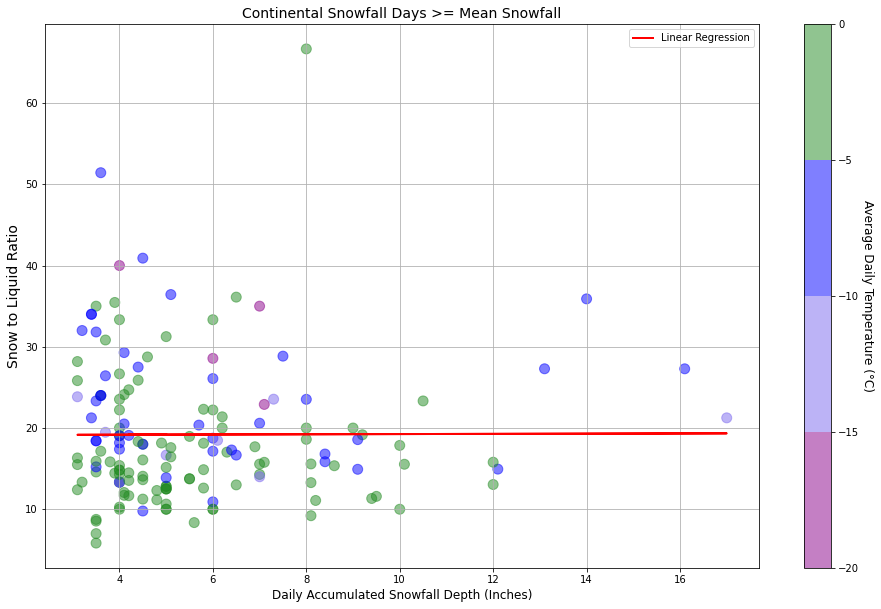

          Name  Snow Mean (in)  Ratio Mean  Snow Stdev (in)  Ratio Stdev  \
0  Continental             3.1      20.729            2.612        9.738   

   Slope  R^2  
0  0.013  0.0  


In [14]:
continental = SLRanalysis(continental_region)

continental.calculate_snow_ratio()
continental.plot_snow_ratio('Continental')
continental.compute_region_stats()
continental.make_table()

### Map of observation sites studied: 

In [15]:
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER,LATITUDE_FORMATTER
from cartopy.mpl.geoaxes import GeoAxes
import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt
from scipy.ndimage.filters import gaussian_filter

import matplotlib.transforms as mtransforms

In [16]:
def get_station_info(plottype):
    if plottype[0] == 'mountain':
        stationids = ['Alta UT','Vail CO','Jackson WY','Steamboat Springs CO']
        lats= [40.59, 39.64, 43.48, 40.49]
        lons= [248.63, 253.85, 249.5, 253.1]
    return stationids,lats,lons 
  
    if plottype[1] =='coastal':
        stationids = ['Tahoe City CA','Mt. Hood OR']
        lats= [39.16, 45.30]
        lons= [239.64, 238.1]
    return stationids,lats,lons
    
def make_map_axes_and_draw_land_areas(): ### Creating Cartopy base map

    plt.figure(figsize=(10, 8))
    proj=ccrs.Mercator()
    
    stamen_terrain = cimgt.StamenTerrain()
    
    ax = plt.axes(projection=stamen_terrain.crs)
    ax.set_extent([230, 260, 35, 49])
    
    ax.add_image(stamen_terrain, 8)
    
    grids = ax.gridlines(xlocs=np.arange(-180, 0, 10), ylocs=np.arange(-90, 90, 5), draw_labels=True)
    grids.xlabels_top = False
    grids.ylabels_right = False
    grids.xformatter = LONGITUDE_FORMATTER
    grids.yformatter = LATITUDE_FORMATTER
    ax.coastlines(resolution='50m')
    ax.add_feature(cfeature.BORDERS)
    ax.add_feature(cfeature.STATES.with_scale('50m'))
    
    geodetic_transform = ccrs.Geodetic()._as_mpl_transform(ax)
    text_transform = mtransforms.offset_copy(geodetic_transform, units='dots', x=10)
    statnids = ['Tahoe City CA','Alta UT','Vail CO','Jackson WY','Mt. Hood OR','Steamboat Springs CO']
    statlats = [39.16, 40.59, 39.64, 43.48, 45.30, 40.49]
    statlons = [239.64, 245.63, 253.85, 249.5, 238.1, 253.1]
    
    for i in range(len(statlons)):
        plt.text(statlons[i], statlats[i], statnids[i],
                 verticalalignment='bottom', horizontalalignment='left',
                 transform=text_transform,
                 bbox=dict(facecolor='sandybrown', alpha=0.5, boxstyle='round'))   
    return ax

def make_map_plot(sigma=1, plot_stations=None, plot_temps=False, plot_temp_adv=False):

    #initialize Cartopy map
    m = make_map_axes_and_draw_land_areas()
    
    data_proj = ccrs.PlateCarree()
    
    if plot_stations != None:
        star_color = 'red'
        
        mountain_lats= [40.59,  43.48]
        mountain_lons= [248.63,  249.5]
        #Plot the stations as stars
        
        coast_lats= [39.16, 45.30]
        coast_lons= [239.64, 238.1]
        
        cont_lats = [39.64,  40.49]
        cont_lons = [253.85,  253.1]
        m.scatter(mountain_lons,mountain_lats, transform=data_proj, color=star_color,marker='*',s=200, label = 'Intermountain Sites', alpha=1)
        
        star_color = 'magenta'
        
        m.scatter(coast_lons,coast_lats, transform=data_proj, color=star_color,marker='*',s=200, label = 'Coastal Sites', alpha=1)
        
        star_color = 'blue'
        m.scatter(cont_lons,cont_lats, transform=data_proj, color=star_color,marker='*',s=200, label = 'Continental Sites', alpha=1)
    plt.legend(loc=3)    
    plt.title('Sites Used')
    
    plt.savefig('sites_used.png')
    
    plt.show()

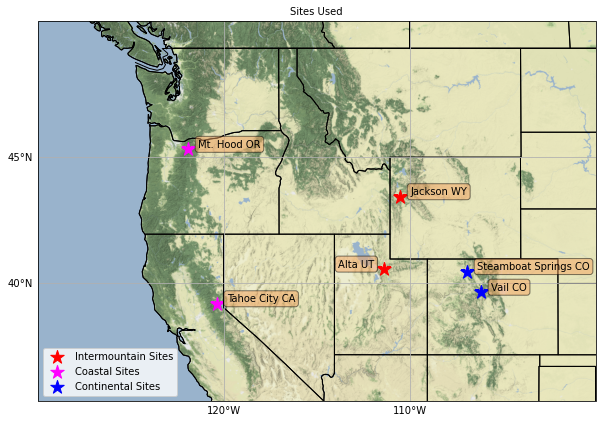

In [17]:
import warnings
warnings.filterwarnings('ignore')

make_map_plot(sigma=0.5,plot_stations=['mountain','coastal'])